In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from livelossplot.inputs.tf_keras import PlotLossesCallback
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Paths and parameters
best_cars_model_path = 'best_cars_model.h5'
train_path = 'data/train'
valid_path = 'data/valid'
TARGET_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
N_EPOCHS = 100

# Load annotations
column_names = ['filename', 'x_min', 'y_min', 'x_max', 'y_max', 'class']
train_annotations = pd.read_csv(os.path.join(train_path, '_annotations.csv'), header=None, names=column_names)
valid_annotations = pd.read_csv(os.path.join(valid_path, '_annotations.csv'), header=None, names=column_names)
mean = np.array([0.4708, 0.4602, 0.4550])
std = np.array([0.2593, 0.2584, 0.2634])

In [3]:
def select_random_classes(annotations, num_classes):
  unique_classes = annotations['class'].unique()
  selected_classes = np.random.choice(unique_classes, size=num_classes, replace=False)
  return selected_classes

def filter_annotations(annotations, selected_classes):
  return annotations[annotations['class'].isin(selected_classes)]

def create_generator(datagen, annotations, path, shuffle=True, max_num_classes=None):
  if max_num_classes:
    selected_classes = select_random_classes(annotations, num_classes=max_num_classes)
    annotations = filter_annotations(annotations, selected_classes)

  return datagen.flow_from_dataframe(
    annotations,
    directory=path,
    x_col='filename',
    y_col='class',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=shuffle
  )

In [4]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5]
)
train_datagen.mean = mean
train_datagen.std = std

test_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True
)
test_datagen.mean = mean
test_datagen.std = std

train_generator = create_generator(train_datagen, train_annotations, train_path)
test_generator = create_generator(test_datagen, valid_annotations, valid_path, shuffle=False)

Found 19317 validated image filenames belonging to 196 classes.
Found 1622 validated image filenames belonging to 196 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


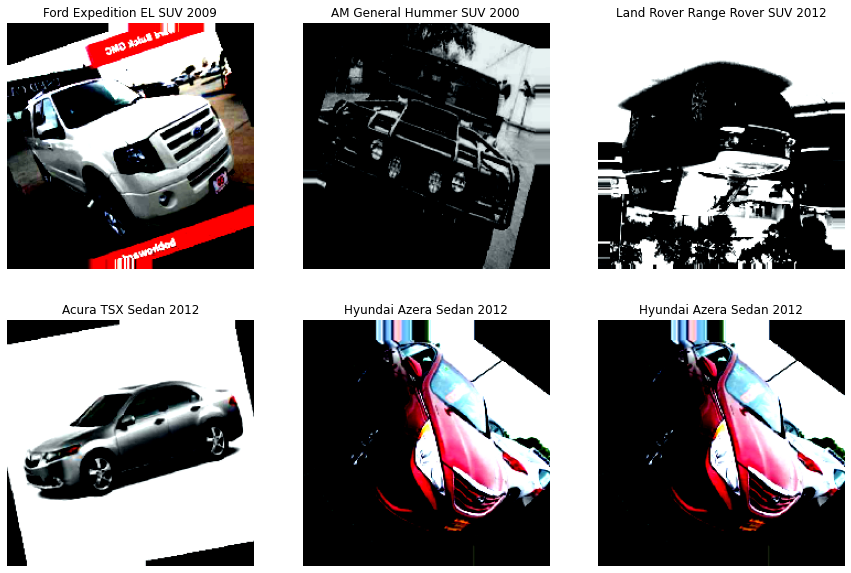

In [5]:
def plot_random_images_with_labels(generator, num_images=6):
    images, labels = next(generator)
    labels = np.argmax(labels, axis=1)

    class_indices = generator.class_indices
    class_labels = {v: k for k, v in class_indices.items()}

    plt.figure(figsize=(15, 10))
    
    for i in range(num_images):
        index = np.random.randint(0, len(images))
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[index])
        plt.title(class_labels[labels[index]])
        plt.axis('off')
    
    plt.show()

plot_random_images_with_labels(train_generator)

In [6]:
def create_model(input_shape, n_classes, optimizer='adam', fine_tune=0):
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
  
  if fine_tune > 0:
    for layer in base_model.layers[:-fine_tune]:
      layer.trainable = False
  else:
    for layer in base_model.layers:
      layer.trainable = False

  top_model = base_model.output
  top_model = Flatten()(top_model)
  top_model = Dense(512, activation='relu')(top_model)
  top_model = BatchNormalization()(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(256, activation='relu')(top_model)
  top_model = BatchNormalization()(top_model)
  top_model = Dropout(0.5)(top_model)
  output_layer = Dense(n_classes, activation='softmax')(top_model)
  
  model = Model(inputs=base_model.input, outputs=output_layer)

  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  
  return model

In [7]:
# Defining model
num_classes = len(train_generator.class_indices)

model = create_model(input_shape=INPUT_SHAPE, n_classes=num_classes, optimizer=Adam(learning_rate=0.00001), fine_tune=3)

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
# Callbacks
plot_loss = PlotLossesCallback()
checkpoint = ModelCheckpoint(best_cars_model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)

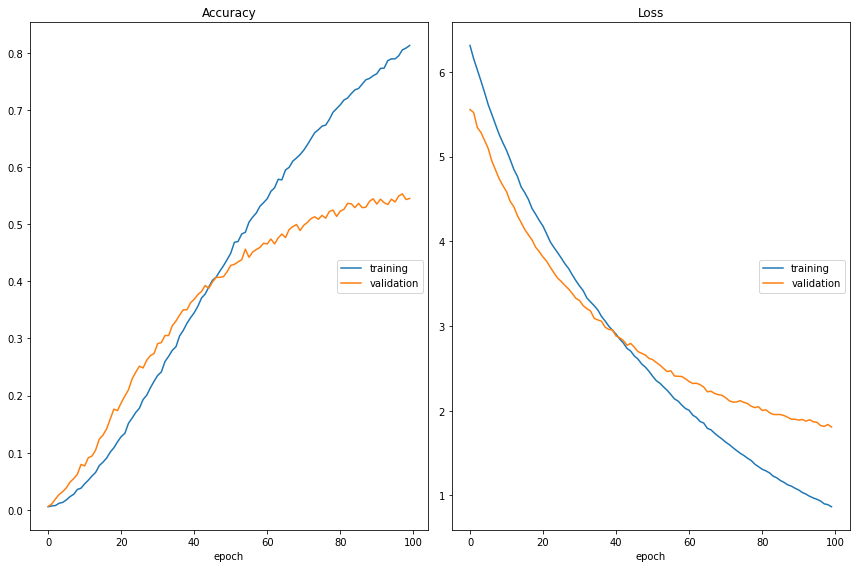

Accuracy
	training         	 (min:    0.006, max:    0.813, cur:    0.813)
	validation       	 (min:    0.006, max:    0.553, cur:    0.545)
Loss
	training         	 (min:    0.867, max:    6.311, cur:    0.867)
	validation       	 (min:    1.808, max:    5.555, cur:    1.808)

Epoch 00100: val_loss improved from 1.81481 to 1.80847, saving model to best_cars_model.h5
604/604 [==============================] - 179s 297ms/step - loss: 0.8670 - acc: 0.8127 - val_loss: 1.8085 - val_acc: 0.5450


In [9]:
# Train the model
history = model.fit(
  train_generator,
  epochs=N_EPOCHS,
  validation_data=test_generator,
  callbacks=[plot_loss, checkpoint, early_stop, reduce_lr],
  verbose=1
)

In [10]:
# Load the best model
best_model = load_model(best_cars_model_path)

# Evaluation
train_loss, train_acc = best_model.evaluate(train_generator, verbose=0)
print(f'Train loss: {train_loss}')
print(f'Train accuracy: {train_acc}')

test_loss, train_acc = best_model.evaluate(test_generator, verbose=0)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {train_acc}')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train loss: 0.27194573114693954
Train accuracy: 0.9837448596954346
Test loss: 1.8084727104972391
Test accuracy: 0.5450061559677124


In [11]:
# Prediction and metrics
predictions = best_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

In [12]:
confusion_mtx = confusion_matrix(true_classes, predicted_classes)
confusion_mtx

array([[7, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 4, 0, 0],
       [0, 0, 0, ..., 0, 3, 0],
       [0, 0, 0, ..., 0, 0, 8]])

In [13]:
print('Classification Report')
print(classification_report(true_classes, predicted_classes))

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.71      0.71      0.71         7
           2       0.00      0.00      0.00         2
           3       0.50      0.86      0.63         7
           4       0.55      0.67      0.60         9
           5       0.83      0.50      0.62        10
           6       0.75      0.60      0.67         5
           7       0.50      0.11      0.18         9
           8       0.33      0.50      0.40         6
           9       0.67      0.33      0.44         6
          10       0.44      1.00      0.62         4
          11       0.50      0.18      0.27        11
          12       0.50      0.33      0.40         9
          13       0.43      0.38      0.40         8
          14       0.20      0.09      0.13        11
          15       0.71      0.42      0.53        12
          16       0.20      0.15      0.17        13
     

/home/raulscoelho/miniconda3/envs/tensorflow-directml/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/raulscoelho/miniconda3/envs/tensorflow-directml/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/raulscoelho/miniconda3/envs/tensorflow-directml/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh